## Problem 1: Based on Table in above Scenario, estimate the expected win rate for a bid response at a given price (prices are listed in table). State your assumptions clearly and provide the steps on how you arrived at your answer.

### So basically we have to come up with a model that can predict the win rate for a bid response at a given price. 
### The win rate is the probability that a bid response will win the auction at a given price.
### We can use a logistic regression model to predict the win rate. The logistic regression model is a binary classification model that can predict the probability of a binary outcome. In this case, the binary outcome is whether a bid response will win the auction or not. 

## Read Input Data and Get Probaility of Winning at a Given Price

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import os, sys

In [2]:
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, 'data')
FILE_PATH = os.path.join(DATA_PATH, 'input', 'aggregate_auction.csv')

In [3]:
# Read Input Table
auction_events = pd.read_csv(FILE_PATH)
auction_events

,app,bid_price,win,events
0,A,0.01,0,100000
1,A,0.01,1,0
2,A,0.10,0,7000
3,A,0.10,1,3000
4,A,0.20,0,8000000
5,A,0.20,1,2000000
6,A,0.40,0,700000
7,A,0.40,1,300000
8,A,0.50,0,80000
9,A,0.50,1,20000


In [4]:
auction_events['bid_price'].nunique()

10

### We have total 10 different prices and the corresponding win rates for each price. 
### The data size is not large enough to do proper model training and doing train-val-test split will lead to very small data size for training.
### Let's explore if we can build some heuristic based decisions

In [5]:
event_counts = auction_events.groupby('bid_price')['events'].sum().reset_index().set_index('bid_price').to_dict()['events']
event_counts

{0.01: 100000,
 0.1: 10000,
 0.2: 10000000,
 0.4: 1000000,
 0.5: 100000,
 0.75: 10000,
 1.0: 1000,
 2.0: 100,
 5.0: 10,
 9.0: 1}

In [6]:
#Add a column in auction_events 
auction_events['total_events'] = auction_events['bid_price'].apply(lambda x: event_counts[x])

In [7]:
# Keep only the columns for the wins
auction_events = auction_events[auction_events['win'] == 1]
auction_events.head()

,app,bid_price,win,events,total_events
1,A,0.01,1,0,100000
3,A,0.10,1,3000,10000
5,A,0.20,1,2000000,10000000
7,A,0.40,1,300000,1000000
9,A,0.50,1,20000,100000


In [8]:
# add win rate column
auction_events['win_rate'] = auction_events['events'] / auction_events['total_events']
auction_events.head()

/var/folders/c8/zycq9f9148x9y4_9krjnpblsj3zskx/T/ipykernel_2629/1027027971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auction_events['win_rate'] = auction_events['events'] / auction_events['total_events']


,app,bid_price,win,events,total_events,win_rate
1,A,0.01,1,0,100000,0.0
3,A,0.10,1,3000,10000,0.3
5,A,0.20,1,2000000,10000000,0.2
7,A,0.40,1,300000,1000000,0.3
9,A,0.50,1,20000,100000,0.2


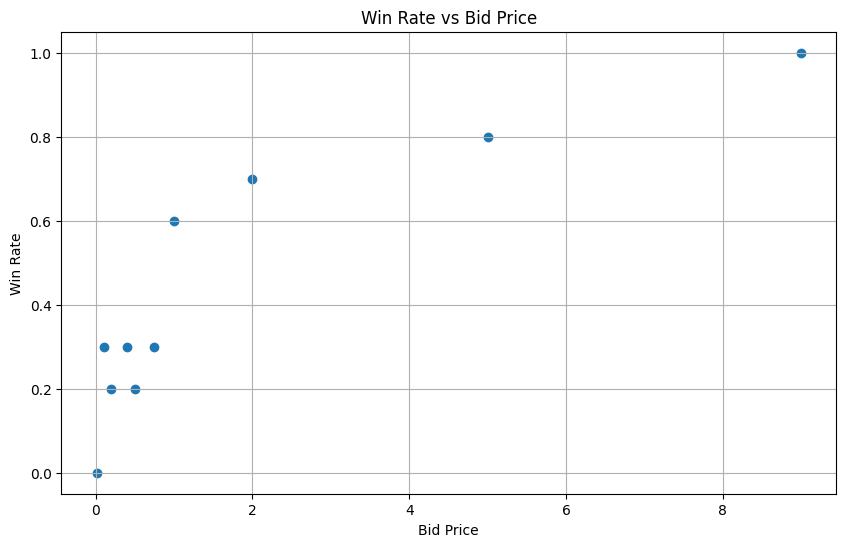

In [9]:
# Let's plt win_rate with bid_price to see if there is any pattern

import matplotlib.pyplot as plt

# Let's plot the same graph with grid lines
plt.figure(figsize=(10, 6))
plt.scatter(auction_events['bid_price'], auction_events['win_rate'])
plt.xlabel('Bid Price')
plt.ylabel('Win Rate')
plt.title('Win Rate vs Bid Price')
plt.grid(True)
plt.show()




### The chart does show a good logistic curve. We can use this curve to predict the win rate for a bid response at a given price.


### Fitting a logistic regression model with only 10 data points would be prone to overfitting.
### Let's use Leave One Out Cross Validation to estimate the win rate for a bid response at a given price, while fitting Logistic Regression model


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score

In [11]:
# Let's create X and y for the model
X = auction_events[['bid_price']]
y = auction_events['win_rate']

In [12]:
X.head()

,bid_price
1,0.01
3,0.10
5,0.20
7,0.40
9,0.50


In [13]:
# y contains a series of float values. We need to convert it to binary values
# Let's convert y to binary values
# We need to select a threshold to convert the win_rate to binary values. Looking at the chart, we can select 0.6 as the threshold
y = (y >= 0.6).astype(int)

In [14]:
# Fit the model
model = LogisticRegression(random_state=100)
loo = LeaveOneOut()
acc_scores = []
f1_scores = []

for train_idx, test_idx in loo.split(X):
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the model and make predictions
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Calculate the accuracy and F1 score
    acc_scores.append(accuracy_score(y_test, prediction))
    f1_scores.append(f1_score(y_test, prediction))
    

print("Average accuracy:", sum(acc_scores) / len(acc_scores))
print("Average F1 Score:", sum(f1_scores) / len(f1_scores))

Average accuracy: 0.8
Average F1 Score: 0.2


/Users/sukant.kumar/Documents/personal/assignment/verve/verve-data-science-interview/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sukant.kumar/Documents/personal/assignment/verve/verve-data-science-interview/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sukant.kumar/Documents/personal/assignment/verve/verve-data-science-interview/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined 

### As expected, the Accuracy is high, but we are getting a low F1 Score
### There is not enough data to train a proper model.

### Let's check if we add some regularisation, will that help or not

In [15]:
# let's run the same kind of models, but with some added regularization
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, f1_score

# Let's create X and y for the model
X = auction_events[['bid_price']]
y = auction_events['win_rate']

# y contains a series of float values. We need to convert it to binary values
# Let's convert y to binary values
# We need to select a threshold to convert the win_rate to binary values. Looking at the chart, we can select 0.6 as the threshold
y = (y >= 0.6).astype(int)

# Fit the model
model = LogisticRegression(random_state=100, C=0.5)

loo = LeaveOneOut()
acc_scores = []
f1_scores = []

for train_idx, test_idx in loo.split(X):
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the model and make predictions
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Calculate the accuracy and F1 score
    acc_scores.append(accuracy_score(y_test, prediction))
    f1_scores.append(f1_score(y_test, prediction))

print("Average accuracy:", sum(acc_scores) / len(acc_scores))
print("Average F1 Score:", sum(f1_scores) / len(f1_scores))

Average accuracy: 0.8
Average F1 Score: 0.2


/Users/sukant.kumar/Documents/personal/assignment/verve/verve-data-science-interview/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sukant.kumar/Documents/personal/assignment/verve/verve-data-science-interview/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sukant.kumar/Documents/personal/assignment/verve/verve-data-science-interview/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined 

## Even adding regularisation is not helping much. The model is still overfitting the data.
### Let's just fit a simple logistic curve to the data using scipt and estimate the coefficients of the curve

In [16]:
auction_events

,app,bid_price,win,events,total_events,win_rate
1,A,0.01,1,0,100000,0.0
3,A,0.10,1,3000,10000,0.3
5,A,0.20,1,2000000,10000000,0.2
7,A,0.40,1,300000,1000000,0.3
9,A,0.50,1,20000,100000,0.2
11,A,0.75,1,3000,10000,0.3
13,A,1.00,1,600,1000,0.6
15,A,2.00,1,70,100,0.7
17,A,5.00,1,8,10,0.8
19,A,9.00,1,1,1,1.0


In [17]:
#Import function from scipy
from scipy.optimize import curve_fit

In [18]:
# Define the logistic function
def logistic_function(x, beta_0, beta_1):
    return 1 / (1 + np.exp(-(beta_0 + beta_1 * x)))

In [19]:
# Get numpy arrays
x = auction_events['bid_price'].values
y = auction_events['win_rate'].values

In [20]:
# Fit the logistic function to the data
params, covariance = curve_fit(logistic_function, x, y, p0=[0, 1])  # Initial guess for beta_0 and beta_1


In [21]:
# Extract the coefficients
beta_0, beta_1 = params
print(f"Intercept (beta_0): {beta_0}")
print(f"Coefficient (beta_1): {beta_1}")

Intercept (beta_0): -1.6248611920057825
Coefficient (beta_1): 1.3824479363977695


In [22]:
def get_win_prob(bid_price):
    return logistic_function(bid_price, beta_0, beta_1)

### We'll be using this function - get_win_prob() to get the win rate for a bid response at a given price

## Problem 2: We receive money from our advertisers if we deliver them a win. Lets say that our advertiser is willing to pay $0.50 per win. This then becomes the upper bound for the bid valuation that we can submit in response to the publisher. For example, if we submit a bid response of $0.40 and we win, then the advertiser pays us $0.50, we pay $0.40 to the publisher and we made a net revenue of $0.10 .

## If our goal was to maximize net revenue, what is the most optimal bid valuation we should send in our response? Use your estimations from Problem1 and all other available information.

### Approach
* First we need to calulcate total no of events, so lets take the sum of all the events
* The ADVERTISER_PRICE is fixed at $0.50
* We need to calculate the net revenue for each bid price and then select the bid price which gives the maximum net revenue
* We have created a logistic curve where we can get the win rate for a bid response (PRICE) at a given price
* This PRICE,p will give us the expected probability of Winning --> Using that we'll know how many events, we'll win at each price
* The upper limit for PRICE is the ADVERTISER_PRICE. We'll vary the price in the range [0.01 - 0.50] and calculate the profit for each price
* Profit = (ADVERTISER_PRICE - PRICE) * No of Wins
* We'll calculate the profit for each price and then select the price which gives the maximum profit

In [23]:
TOTAL_EVENTS = auction_events['total_events'].sum()
ADVERTISER_PRICE = 0.5

In [33]:
def get_total_wins(price):
    win_prob = get_win_prob(price)
    expected_wins = win_prob * TOTAL_EVENTS
    return expected_wins

def get_profit_margin(price):
    return ADVERTISER_PRICE - price

def get_profit(price):
    expected_wins = get_total_wins(price)
    profit_margin = get_profit_margin(price)
    return expected_wins * profit_margin


In [34]:
price_ranges = [p/100 for p in range(1,51)]
price_ranges[0], price_ranges[-1]

(0.01, 0.5)

In [35]:
win_counts = [get_total_wins(price) for price in price_ranges]
profit_margins = [get_profit_margin(price) for price in price_ranges]

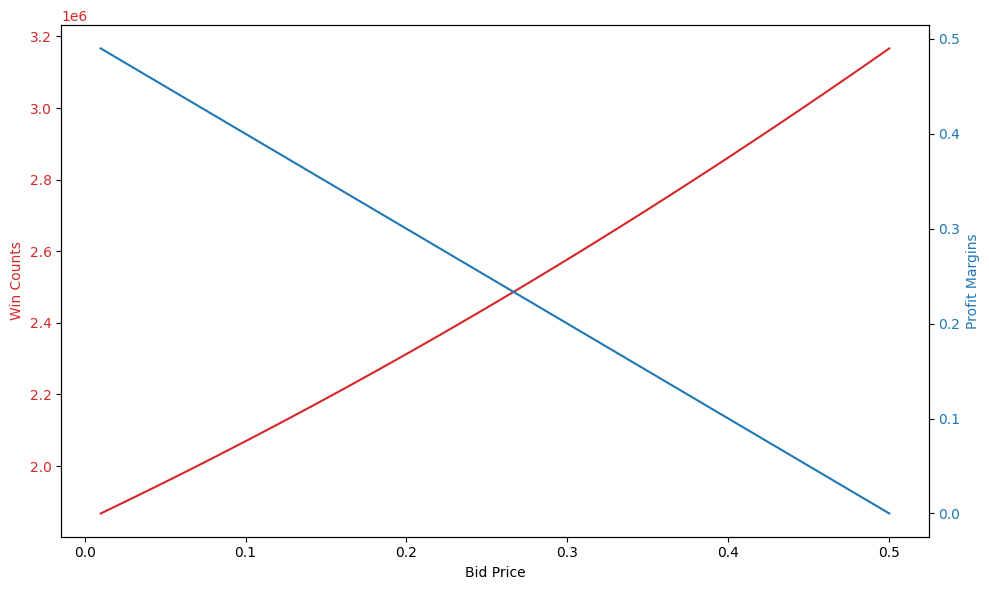

In [37]:
# Let's plot bid price on X-axis and win_counts and profit margins on Y-axis in the same plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Bid Price')
ax1.set_ylabel('Win Counts', color=color)
ax1.plot(price_ranges, win_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Profit Margins', color=color)
ax2.plot(price_ranges, profit_margins, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## As we increase the bid price, the profit margin reduces linearly, as the advertiser price is fixed at $0.50
## With increasing prices, the win_rate increases, which in turn increases the number of win events

## Total Net Profit is product of win_rate and profit_margin
## From the graph it seems like the optimal bid price is around $0.30

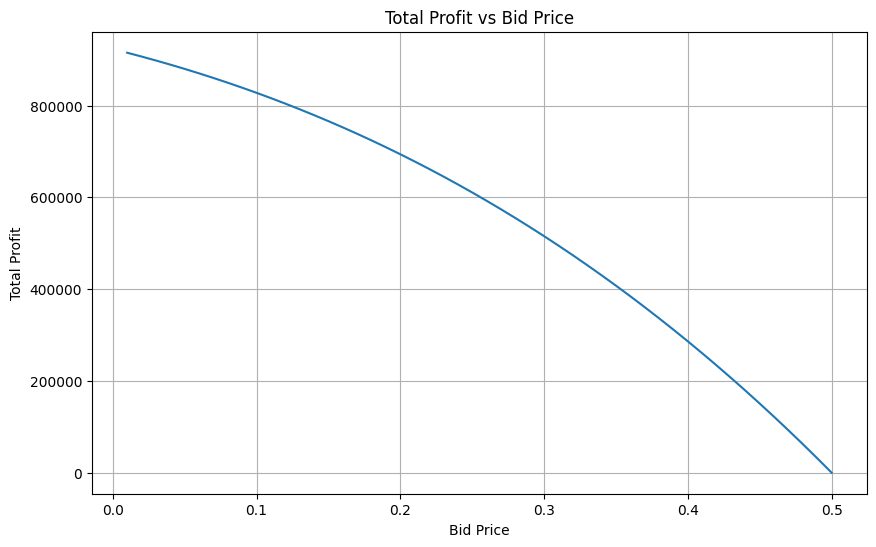

In [38]:
total_profit = [get_profit(price) for price in price_ranges]

plt.figure(figsize=(10, 6))
plt.plot(price_ranges, total_profit)
plt.xlabel('Bid Price')
plt.ylabel('Total Profit')
plt.title('Total Profit vs Bid Price')

plt.grid(True)
plt.show()

## Total Net Profit is product of win_rate and profit_margin
## From the graph, the curve of Total Net Profit has slight parabolic shape, but overall it seems a sloping downwards curve
## From this graph, it would suggest that the optimal price is near the start of the range
## If that i true, it would mean that the total profit is dominated by the PROFIT_MARGIN and not the WIN_RATE

In [39]:
np.argmax(total_profit), price_ranges[np.argmax(total_profit)]

(np.int64(0), 0.01)

## Based on this analysis, it seems that the lower bid price is more optimal than the higher bid price

# The optimal bid price comes around to : $0.01